In [1]:
from scipy.stats import ttest_ind

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

In [3]:
import seaborn as sns

In [4]:
pd.set_option('mode.chained_assignment', None)

In [5]:
from util import spacy_get_sents, spacy_tokenize_text, nlp, get_entities

2023-05-13 18:28:54 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-13 18:28:55 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-05-13 18:28:55 INFO: Using device: cpu
2023-05-13 18:28:55 INFO: Loading: tokenize
2023-05-13 18:28:55 INFO: Loading: pos
2023-05-13 18:28:56 INFO: Done loading processors!


In [6]:
df = pd.read_csv("Data/df_with_texts.csv", index_col=0)

In [7]:
df = df.replace(r'\n',' ', regex=True)
df

,Person,Subcategory,Category,Text
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...
...,...,...,...,...
7053,Uhwudong,Korean writers,Writers,"Eowudong or Uhwudong (어우동, 於宇同; 1440 - 18 Octo..."
5383,Óttar M. Norðfjörð,Icelandic writers,Writers,Óttar Martin Norðfjörð (born 1980) is an Icela...
4093,Claude Phillips,English writers,Writers,Sir Claude Phillips (29 January 1846 – 9 Augus...
7477,Francis Moto,Malawian writers,Writers,Professor Francis P. B. Moto (born 1952) is a ...


# **Count sentences of each category**

In [8]:
astronauts = df.loc[df['Category'] == 'Astronauts'] #subframe of astronauts 
astronauts.head()

,Person,Subcategory,Category,Text
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...


In [9]:
writers = df.loc[df['Category'] == 'Writers'] #subframe of writers
writers.head()

,Person,Subcategory,Category,Text
10112,Sagit Agish,Soviet writers,Writers,"Sagit Agish (1904–1973) was a Bashkir poet, wr..."
9851,Preller Geldenhuys,South African writers,Writers,(Prop) Preller Geldenhuys was a pilot in the R...
1005,Marcelo Kohen,Argentine writers,Writers,"Marcelo Gustavo Kohen (born August 11, 1957) i..."
6902,Masanobu Fukuoka,Japanese writers,Writers,"Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: Fu..."
9791,James Gregory (prison officer),South African writers,Writers,James Gregory (7 November 1941 – 2003) was the...


In [10]:
writers["Sentences"] = writers['Text'].apply(spacy_get_sents) # Apply the function to the text colum and create a new column with the output
writers['Num_sentences'] = writers['Sentences'].apply(lambda x: len(x)) # Now we get the number of sentences of each article 

In [11]:
writers.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences
10112,Sagit Agish,Soviet writers,Writers,"Sagit Agish (1904–1973) was a Bashkir poet, wr...","[Sagit Agish (1904–1973) was a Bashkir poet, w...",13
9851,Preller Geldenhuys,South African writers,Writers,(Prop) Preller Geldenhuys was a pilot in the R...,[(Prop) Preller Geldenhuys was a pilot in the ...,10
1005,Marcelo Kohen,Argentine writers,Writers,"Marcelo Gustavo Kohen (born August 11, 1957) i...","[Marcelo Gustavo Kohen (born August 11, 1957) ...",40
6902,Masanobu Fukuoka,Japanese writers,Writers,"Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: Fu...","[Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: F...",168
9791,James Gregory (prison officer),South African writers,Writers,James Gregory (7 November 1941 – 2003) was the...,[James Gregory (7 November 1941 – 2003) was th...,29


In [12]:
#We do the same with astronauts...

astronauts['Sentences'] = astronauts['Text'].apply(spacy_get_sents)
astronauts['Num_sentences'] = astronauts['Sentences'].apply(lambda x: len(x))

In [13]:
len(astronauts["Sentences"].iloc[0])

41

In [14]:
def calculate_stats(data):
    """
    This function takes a list of numbers as input, and returns a formatted string
    containing the minimum, maximum, and average values.
    """
    minimum = min(data)
    maximum = max(data)
    average = sum(data) / len(data)

    stats_str = f"This is the average: {average} \nThis is the maximum: {maximum} \nThis is the minimum: {minimum}"

    return stats_str

Stats for astronauts article length (in sentences):

In [15]:
print(calculate_stats(astronauts['Num_sentences']))

This is the average: 43.98 
This is the maximum: 324 
This is the minimum: 2


Stats for writers article length (in sentences):

In [16]:
print(calculate_stats(writers['Num_sentences']))

This is the average: 30.695 
This is the maximum: 267 
This is the minimum: 2


# Visualization

### Histograms

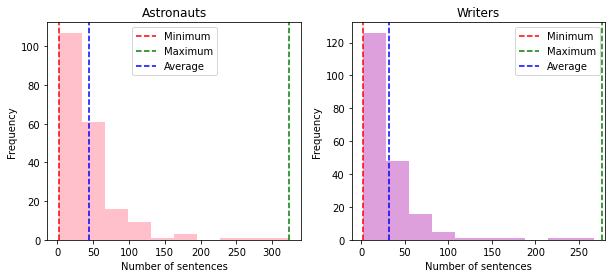

In [17]:
# Create a figure with two subplots, side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first histogram on the left subplot
axs[0].hist(astronauts['Num_sentences'], bins=10,color='pink')
axs[0].axvline(x=2, color='r', linestyle='--', label='Minimum')
axs[0].axvline(x=324, color='g', linestyle='--', label='Maximum')
axs[0].axvline(x=44.25, color='b', linestyle='--', label='Average')
axs[0].set_title('Astronauts')

# Plot the second histogram on the right subplot
axs[1].hist(writers['Num_sentences'], bins=10, color = "plum")
axs[1].axvline(x=2, color='r', linestyle='--', label='Minimum')
axs[1].axvline(x=277, color='g', linestyle='--', label='Maximum')
axs[1].axvline(x=31.37, color='b', linestyle='--', label='Average')
axs[1].set_title('Writers')


# Set the x-axis and y-axis labels for both subplots
for ax in axs:
    ax.set_xlabel('Number of sentences')
    ax.set_ylabel('Frequency')
    ax.legend()

# Show the figure
plt.show()


### Boxplots

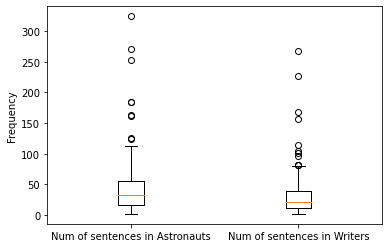

In [18]:
# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the boxplots side-by-side using the "positions" parameter
ax.boxplot([astronauts['Num_sentences'], writers['Num_sentences']], positions=[1, 2])

# Set the labels and limits
ax.set_xticklabels(['Num of sentences in Astronauts', 'Num of sentences in Writers'])
ax.set_xlim(0.5, 2.5)
ax.set_ylabel('Frequency')

# Show the figure
plt.show()

## **Tokenization**

In this section we will perform the tokenization of sentences and the whole articles.

For each category we will calculate:
- The count of tokens per sentence
- The count of tokens per article

We will also compare the number of tokens per article by categories: whether or not one of them has more tokens than the other.

In [19]:
# We will create a column in astronauts DF which will include tokenized sentences of each article. 
# It will be a list of a list of tokens for each article. For normalization all sentences will be lowercased 
# (for the future task of checking vocabulary).

#We apply the the function tokenize_sentence to astronauts and create a new colum with the result
astronauts["tokenized_sentences"] = astronauts["Sentences"].apply(lambda x: 
                                                                  list(
                                                                      map(
                                                                          lambda y: spacy_tokenize_text(y, to_lowercase=True),
                                                                          x
                                                                          )
                                                                      )
                                                                 )
astronauts.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences,tokenized_sentences
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an...","[Jeanette Jo Epps (born November 3, 1970) is a...",41,"[[jeanette, jo, epps, born, november, 3, 1970,..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...,[Sergei Vasilyevich Avdeyev (Сергей Васильевич...,28,"[[sergei, vasilyevich, avdeyev, сергей, василь..."
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...,[Matthias Josef Maurer (born 18 March 1970) is...,31,"[[matthias, josef, maurer, born, 18, march, 19..."
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...,[Andriyan Grigoryevich Nikolayev (Chuvash and ...,52,"[[andriyan, grigoryevich, nikolayev, chuvash, ..."
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...,[Gennady Mikhailovich Manakov (Russian: Геннад...,7,"[[gennady, mikhailovich, manakov, russian, ген..."


In [20]:
astronauts.to_csv('TokenizedDF/output_astronauts.csv', index=False)

In [21]:
# Repeat for writers
writers["tokenized_sentences"] = writers["Sentences"].apply(lambda x: 
                                                                  list(
                                                                      map(
                                                                          lambda y: spacy_tokenize_text(y, to_lowercase=True),
                                                                          x
                                                                          )
                                                                      )
                                                      )
writers.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences,tokenized_sentences
10112,Sagit Agish,Soviet writers,Writers,"Sagit Agish (1904–1973) was a Bashkir poet, wr...","[Sagit Agish (1904–1973) was a Bashkir poet, w...",13,"[[sagit, agish, 1904–1973, bashkir, poet, writ..."
9851,Preller Geldenhuys,South African writers,Writers,(Prop) Preller Geldenhuys was a pilot in the R...,[(Prop) Preller Geldenhuys was a pilot in the ...,10,"[[prop, preller, geldenhuys, pilot, rhodesian,..."
1005,Marcelo Kohen,Argentine writers,Writers,"Marcelo Gustavo Kohen (born August 11, 1957) i...","[Marcelo Gustavo Kohen (born August 11, 1957) ...",40,"[[marcelo, gustavo, kohen, born, august, 11, 1..."
6902,Masanobu Fukuoka,Japanese writers,Writers,"Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: Fu...","[Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: F...",168,"[[masanobu, fukuoka, japanese, 福岡, 正信, hepburn..."
9791,James Gregory (prison officer),South African writers,Writers,James Gregory (7 November 1941 – 2003) was the...,[James Gregory (7 November 1941 – 2003) was th...,29,"[[james, gregory, 7, november, 1941, 2003, cen..."


In [22]:
writers.to_csv('TokenizedDF/output_writers.csv', index=False)

Now we count the number of tokens of each sentences and represent the output

In [23]:
#we count the tokens of each sentence

tokens_per_sentence_wr = writers["tokenized_sentences"].apply(lambda x: list(map(lambda y: len(y), x)))
tokens_per_sentence_as = astronauts["tokenized_sentences"].apply(lambda x: list(map(lambda y: len(y), x)))

In [24]:
#We count the total tokens of each row

total_wr= tokens_per_sentence_wr.apply(lambda x: sum(x))
total_as= tokens_per_sentence_as.apply(lambda x: sum(x))

The stats for token count per article for `Writers`:

In [25]:
#We get the min, max and avg
print(calculate_stats(total_wr))

This is the average: 354.4 
This is the maximum: 3818 
This is the minimum: 13


The stats for token count per article for `Astronauts`:

In [26]:
print(calculate_stats(total_as))

This is the average: 557.62 
This is the maximum: 4449 
This is the minimum: 29


# **Visualization: Tokens**

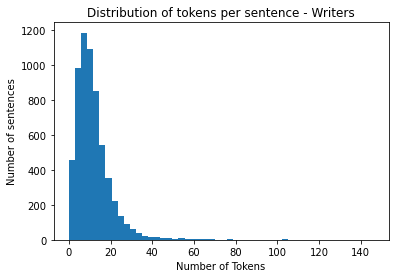

In [27]:
# Since tokens in our dataframe are in a list of list we need to flatten it first
tokens_per_sentence_wr_flat = np.concatenate(list(tokens_per_sentence_wr))

#Histogram of tokens per sentence - Writers
plt.hist(tokens_per_sentence_wr_flat, bins=50)


# Add labels and a title to the plot
plt.xlabel("Number of Tokens")
plt.ylabel("Number of sentences")
plt.title("Distribution of tokens per sentence - Writers")

# Show the plot
plt.show()

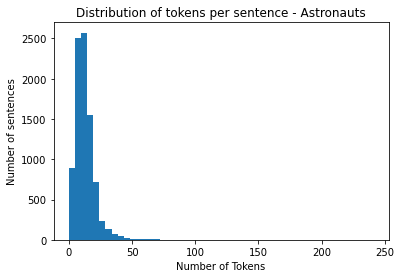

In [28]:
# Since tokens in our dataframe are in a list of list we need to flatten it first
tokens_per_sentence_as_flat = np.concatenate(list(tokens_per_sentence_as))

#Histogram of tokens per sentence - Astronauts
plt.hist(tokens_per_sentence_as_flat, bins=50)

# Add labels and a title to the plot
plt.xlabel("Number of Tokens")
plt.ylabel("Number of sentences")
plt.title("Distribution of tokens per sentence - Astronauts")

# Show the plot
plt.show()

Histograms of tokens per category per article:

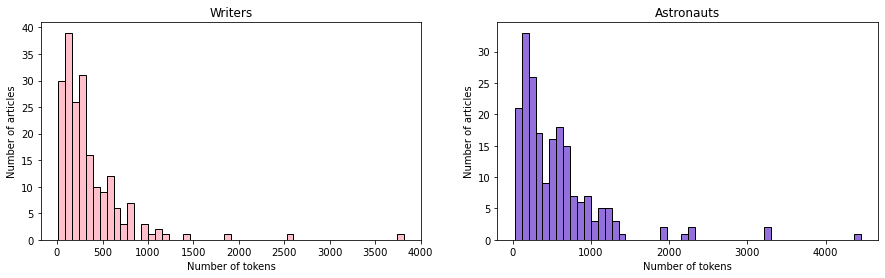

In [29]:
# Create a figure with two subplots, side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Plot the first histogram on the left subplot
axs[0].hist(total_wr, bins=50,color='pink',edgecolor='black')
axs[0].set_title('Writers')

# Plot the second histogram on the right subplot
axs[1].hist(total_as, bins=50, color = "mediumpurple",edgecolor='black')
axs[1].set_title('Astronauts')


# Set the x-axis and y-axis labels for both subplots
for ax in axs:
    ax.set_xlabel('Number of tokens')
    ax.set_ylabel('Number of articles')

# Show the figure
plt.show()

From what we have seen above with comparison of averages, and here from distributions, we can make a hypothesis that average number of tokens per article is higher for `Astronauts` than it is for `Writers`.

$H_{0}$: Average number of tokens per article is the same for `Astronauts` and `Writers`.

$H_{1}$: Average number of tokens per article is not the same for `Astronauts` and `Writers`.

Let's set p-value to be < 0.05 for the experiment.

In [30]:
ttest_ind(total_as, total_wr)

Ttest_indResult(statistic=4.097121785719359, pvalue=5.0707218792719064e-05)

P-value is very small and it means we can reject the null-hypothesis. Since the value of statistic is positive, we can 
accept the theory that average number of tokens is higher for `Astronauts` than for `Writers`, meaning that we can accept the theory that `Astronauts` articles are longer on average.

__________________

# Visualization: Named entities

For this experiment we will extract named entities using Spacy library and compare the article classes: whether or not some of the named entities are more frequent in a particular article class.

In [31]:
#We apply it to the column text of the dataset

entities_as = astronauts["Text"].apply(get_entities)
entities_wr = writers["Text"].apply(get_entities)

In [32]:
from spacy import displacy

#we can dispay the entities to see them more clearly. To show an example we display the entities of one text

displacy.render(nlp(astronauts["Text"].iloc[12]), style='ent', jupyter=True) 

In [33]:
#We make a list of the total entities. Entities_as and entities_wr are arrays of Pandas Series of arrays, 
# so we'll use numpy.concatenate to flatten it to a 1-dimensional array.

list_entities_as = np.concatenate(list(entities_as))
list_entities_wr = np.concatenate(list(entities_wr))

Dataframe with all named entities found in `Astronauts` texts:

In [34]:
entities_as_df = pd.DataFrame(columns=['Entity', 'Count', 'Category'])
entities_as_df.Entity = np.unique(list_entities_as, return_counts=True)[0]
entities_as_df.Count = np.unique(list_entities_as, return_counts=True)[1]
entities_as_df.Category = 'Astronauts'

entities_as_df = entities_as_df.sort_values(by='Count', ascending=False)

Dataframe with all named entities found in `Writers` texts:

In [35]:
entities_wr_df = pd.DataFrame(columns=['Entity', 'Count', 'Category'])
entities_wr_df.Entity = np.unique(list_entities_wr, return_counts=True)[0]
entities_wr_df.Count = np.unique(list_entities_wr, return_counts=True)[1]
entities_wr_df.Category = 'Writers'

entities_wr_df = entities_wr_df.sort_values(by='Count', ascending=False)

Combine the entity DataFrames into one:

In [36]:
entities_df = pd.concat([entities_as_df, entities_wr_df])

<AxesSubplot:xlabel='Entity', ylabel='Count'>

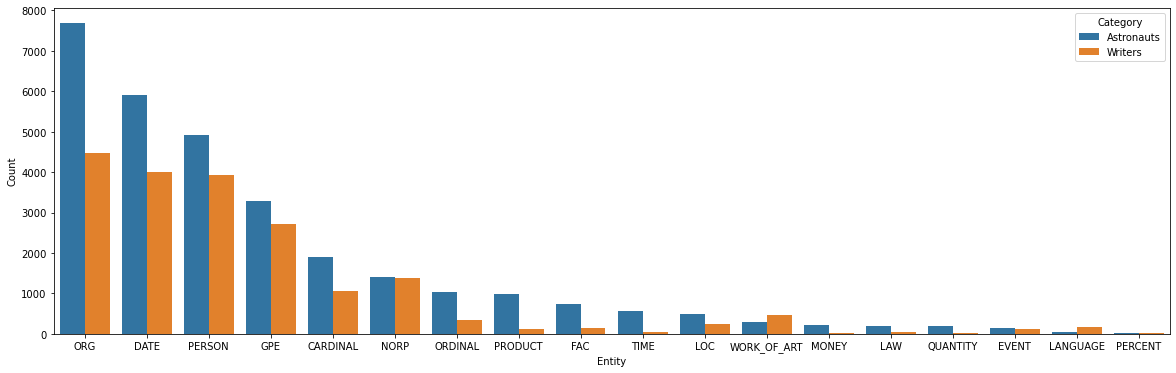

In [37]:
plt.figure(figsize=(20, 6))

sns.barplot(data=entities_df, x='Entity', y='Count', hue='Category')

## T-test

Even though as we have seen above, on average there are fewer tokens for `Writers` articles, we can notice that `WORK_OF_ART` and `LANGUAGE` named entities are more frequently for `Writers` than for `Astronauts`.

We can make a hypothesis that `WORK_OF_ART` and `LANGUAGE` are more frequent in Writers articles than in Astronauts.

$H_{0}$: Average number of `WORK_OF_ART` named entities per article is the same for `Writers` and `Astronauts`.

$H_{1}$: Average number of `WORK_OF_ART` named enitites per article is different for `Writers` and `Astronauts`.

Let's set p-value to be < 0.05. 

Our sample has 200 Writers aritcles and 200 Astronaut articles, since we don't have any information about who have written them, we will consider these samples to be independent and use **scipy.stats.ttest_ind**.

In [38]:
# Count the number of occurences of WORK_OF_ART per article for Writers and Astronauts
wr_wa_count = entities_wr.apply(lambda x: x.count('WORK_OF_ART'))

as_wa_count = entities_as.apply(lambda x: x.count('WORK_OF_ART'))

In [39]:
ttest_ind(wr_wa_count, as_wa_count)

Ttest_indResult(statistic=2.869886482322327, pvalue=0.0043252319651822125)

The p-value is below the threshold we set, therefore, we can reject the null hypothesis and accept the $H_{1}$.

Since the statistic value is positive, we can accept hypothesis that on average count of `WORK_OF_ART` named entities per article is higher for `Writers` articles than for `Astronauts`.

We can repeat the test for `LANGUAGE`.

$H_{0}$: Average number of `LANGUAGE` named entities per article is the same for `Writers` and `Astronauts`.

$H_{1}$: Average number of `LANGUAGE` named enitites per article is different for `Writers` and `Astronauts`.


In [40]:
# Count the number of occurences of LANGUAGE per article for Writers and Astronauts
wr_lang_count = entities_wr.apply(lambda x: x.count('LANGUAGE'))

as_lang_count = entities_as.apply(lambda x: x.count('LANGUAGE'))

ttest_ind(wr_lang_count, as_lang_count)

Ttest_indResult(statistic=2.853940459850125, pvalue=0.004543719493576716)

Once again we can reject the null hypothesis and accept the hypothesis that average number of `LANGUAGE` named entities is higher for `Writers` articles.

# Word frequency

In [41]:
# Combine the already tokenized data
df_tokenized = pd.concat([astronauts, writers])

In [42]:
df_tokenized.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences,tokenized_sentences
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an...","[Jeanette Jo Epps (born November 3, 1970) is a...",41,"[[jeanette, jo, epps, born, november, 3, 1970,..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...,[Sergei Vasilyevich Avdeyev (Сергей Васильевич...,28,"[[sergei, vasilyevich, avdeyev, сергей, василь..."
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...,[Matthias Josef Maurer (born 18 March 1970) is...,31,"[[matthias, josef, maurer, born, 18, march, 19..."
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...,[Andriyan Grigoryevich Nikolayev (Chuvash and ...,52,"[[andriyan, grigoryevich, nikolayev, chuvash, ..."
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...,[Gennady Mikhailovich Manakov (Russian: Геннад...,7,"[[gennady, mikhailovich, manakov, russian, ген..."


In [43]:
# Get the unique categories and subcategories of data

cat = df_tokenized.Category.unique()
sub_cat = df.Subcategory.unique()
len(cat), len(sub_cat)

(2, 115)

In [44]:
# We join all texts by categories
cat_txt = {}
for c in cat:
    cat_txt[c] = df[df['Category']==c].Text.str.cat(sep=' ').lower()

len(cat_txt)

2

In [45]:
# We join all tokens by categories
cat_token = {}
for c in cat:
    # Flattens the data of list of lists in 1-d array
    cat_token[c] = np.concatenate(
        np.concatenate(list(df_tokenized[df_tokenized.Category == c].tokenized_sentences))
    )
len(cat_token)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2

In [46]:
# We join all tokens by subcategories
sub_cat_token = {}
for c in sub_cat:
    # Flattens the data of list of lists in 1-d array
    # Extract tokens from df_tokenized for the needed subcategory
    sub_cat_token[c] = np.concatenate(
        np.concatenate(list(df_tokenized[df_tokenized.Subcategory == c].tokenized_sentences))
    )
len(sub_cat_token)

115

## 50 most frequents words

In [47]:
# we find the 50 most frequents words by categories 
cat_freq_list = []

for cat, v in cat_token.items(): # for each category
    freq_list = list(zip(
                            np.unique(v, return_counts=True)[0],
                            np.unique(v, return_counts=True)[1])
        ) # Get the words and counts in the following format [(word1, 1), (word2, 1)... ]
    

    # Sort by number of occurences and take the 50 first words
    freq_50 =  sorted(freq_list, key=lambda x: x[1], reverse=True)[:50] 
    
    for w, c in freq_50:
        cat_freq_list.append(
            {
                'Word': w,
                'Count': c,
                'Category': cat
            }
        )
    

cat_freq_df = pd.DataFrame(cat_freq_list)
cat_freq_df

,Word,Count,Category
0,space,2382,Astronauts
1,mission,845,Astronauts
2,flight,744,Astronauts
3,nasa,739,Astronauts
4,astronaut,720,Astronauts
...,...,...,...
95,language,105,Writers
96,history,103,Writers
97,college,99,Writers
98,2011,97,Writers


In [48]:
cat_freq_df.to_csv('FrequentWords/top50_freq_word_by_cat.csv')

In [49]:
subcat_freq_list = []

for subcat, v in sub_cat_token.items(): # for each category
    freq_list = list(zip(
                            np.unique(v, return_counts=True)[0],
                            np.unique(v, return_counts=True)[1])
        ) # Get the words and counts in the following format [(word1, 1), (word2, 1)... ]
    

    # Sort by number of occurences and take the 50 first words
    freq_50 =  sorted(freq_list, key=lambda x: x[1], reverse=True)[:50] 
    
    for w, c in freq_50:
        subcat_freq_list.append(
            {
                'Word': w,
                'Count': c,
                'Subcategory': subcat
            }
        )
    

subcat_freq_df = pd.DataFrame(subcat_freq_list)
subcat_freq_df

,Word,Count,Subcategory
0,space,794,American astronauts
1,nasa,492,American astronauts
2,mission,352,American astronauts
3,astronaut,345,American astronauts
4,flight,273,American astronauts
...,...,...,...
5661,series,2,Malaysian writers
5662,shakespeare,2,Malaysian writers
5663,skills,2,Malaysian writers
5664,spelling,2,Malaysian writers


In [50]:
subcat_freq_df.to_csv('FrequentWords/top50_freq_word_by_subcat.csv')

## Wordclouds

This task use the library WordCloud. This library do its own preprocessing so we don't exactly find the same words. We can still see that most word are the same in both the wordclouds and our own list. They seems to have less useless words like 'also', 'from', 'with' ot 'that' whithout loosing small important words like 'ST', 'ISS' or 'one'

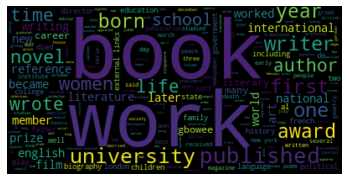

In [51]:
wr_wordcloud = WordCloud(stopwords=STOPWORDS).generate(cat_txt['Writers'])
plt.imshow(wr_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() # we show it
wr_wordcloud.to_file("FrequentWords/Wordclouds/wc_Writers.jpg") # and we save it

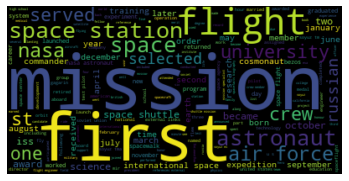

In [52]:
as_wordcloud = WordCloud(stopwords=STOPWORDS).generate(cat_txt['Astronauts'])
plt.imshow(as_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() # we show it
as_wordcloud.to_file("FrequentWords/Wordclouds/wc_Astronauts.jpg") # and we save it

## Compare our top 50 with top 50 from Wordcloud

Get the top 50 words from Wordcloud for Writers:

In [53]:
wr_wordcloud_top = [x for x, y in 
                    sorted([(w, c) for w, c in wr_wordcloud.words_.items()], key=lambda x: x[1], reverse=True)[:50]
                   ] # Sort the wordcloud values by frequency, get top 50, leave only words and drop frequency

Now the same for Astronauts:

In [54]:
as_wordcloud_top = [x for x, y in 
                    sorted([(w, c) for w, c in as_wordcloud.words_.items()], key=lambda x: x[1], reverse=True)[:50]
                   ] # Sort the wordcloud values by frequency, get top 50, leave only words and drop frequency

Get our own selected top 50:

In [55]:
wr_our_top = cat_freq_df[cat_freq_df.Category == 'Writers'].Word
as_our_top = cat_freq_df[cat_freq_df.Category == 'Astronauts'].Word

We can see how many words appear in both tops (Wordcloud and ours) for Writers:

In [56]:
len(set(wr_wordcloud_top).intersection(set(wr_our_top)))

40

We can now have a look at the words in Wordcloud top that were not in our top:

In [57]:
set(wr_wordcloud_top).difference(set(wr_our_top))

{'art',
 'became',
 'first',
 'including',
 'many',
 'one',
 'part',
 'play',
 'reference',
 's'}

In [58]:
set(wr_our_top).difference(set(wr_wordcloud_top))

{'2011',
 'books',
 'early',
 'isbn',
 'peace',
 'references',
 'series',
 'war',
 'works',
 'years'}

We can notice that in our top there are several plural forms that are likely recognized as the same lemma by Wordcloud. 

We can also notice that Wordcloud top includes `one`, `many` and `s` which don't add a lot of meaning.

Interestingly, our top doesn't include `art` which is an important term for `Writers` articles, it may be connected to the fact that having treated plurals and singulars as different forms we missed out on `art` which appeared below top 50.

_____________

Now let's have a look at the tops for Astronauts.

Here the intersection is much lower for our top and Wordcloud top:

In [59]:
len(set(as_wordcloud_top).intersection(set(as_our_top)))

26

Let's have a look the words in Wordcloud top, that are not in our top:

In [60]:
for w in set(as_wordcloud_top).difference(as_our_top):
    print(w, end=', ')

international space, first, became, st, air force, december, returned, two, received, experiment, bezos, space station, august, january, july, award, year, may, march, spacewalk, space shuttle, second, june, one, 

And the words in our top that are not in Wordcloud:

In [61]:
for w in set(as_our_top).difference(as_wordcloud_top):
    print(w, end=', ')

life, program, hours, astronauts, engineer, mir, medal, gagarin, test, school, air, soviet, force, american, degree, center, career, shuttle, pilot, soyuz, aboard, days, station, international, 

First of all, we can notice tokenization difference: Wordcloud tokenizes `international space` as one token and we can see in our top `international` appears as a separate token. The same can also explain words like `station` appearing only in our top but not in Wordcloud top.

We can notice once again that there are a lot of not particularly informational tokens in the top of Wordcloud: like month names, `one`, `first`, `st`. 

Overall, the words that are uniquely in our top seem subjectively more informational for the topic, however, can notice that there are words like `hours` and `days` which may be not very informational and could be included in the stopwords.

___________

# **TRAINING CLASSIFIERS**

In [271]:
from sklearn.utils import shuffle
#Shuffle the data
df_tokenized = shuffle(df_tokenized)

In [272]:
X = df_tokenized.tokenized_sentences.apply(lambda x: np.concatenate(x))
# Join the tokenized sentences into strings
X = [' '.join(tokens) for tokens in X]
Y = df_tokenized['labels_encoded']
Y.shape

(400,)

In [273]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, 
                                                    test_size=0.30, random_state=0)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [275]:
# Using TFIDF vectorizer with pre-tokenized text
tfidf_vectorizer = TfidfVectorizer(max_features=400,
                                   use_idf=True,
                                   stop_words='english',
                                   ngram_range=(1, 2))

# Fit the vectorizer to train and test data
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

# Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train_tf.shape)
print('Test:', X_test_tf.shape)
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))

Train: (280, 400)
Test: (120, 400)
Vocabulary size: 400


In [276]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score

# Create a Perceptron object
perc_filtered = Perceptron(max_iter=5, tol=None, random_state=0)

# Train the model on the training data
perc_filtered.fit(X_train_tf, Y_train)

# Test the model on the test data
Y_pred = perc_filtered.predict(X_test_tf)

# Print out the expected values and the predictions
print( '\nExpected Values:',  list(Y_test) )
print( '\nPredictions:',  Y_pred )

# Print accuracy
print( "Acc:", accuracy_score( Y_test, Y_pred) )


Expected Values: [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0]

Predictions: [0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1
 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1
 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 1 1 0 0]
Acc: 0.9583333333333334


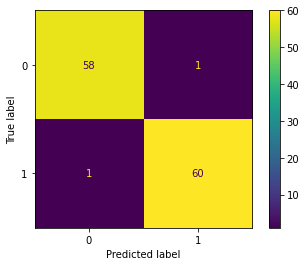

Acc: 0.88


In [277]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

svm_filtered = SVC(random_state=0)

svm_filtered.fit(X_train_tf, Y_train)

Y_pred = svm_filtered.predict(X_test_tf)

cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

print("Acc:", accuracy_score(y_test, predictions))

__________________
## Classification without common words

Now let's attempt to remove the most frequent words and see how it affects the classification:

In [278]:
cat_freq_df= pd.read_csv("FrequentWords/top50_freq_word_by_cat.csv", index_col=0)

In [279]:
common_words_as = cat_freq_df[cat_freq_df.Category == 'Astronauts'].Word.tolist()
common_words_wr = cat_freq_df[cat_freq_df.Category == 'Writers'].Word.tolist()

In [280]:
df_tokenized = shuffle(df_tokenized)

X = df_tokenized.tokenized_sentences.apply(lambda x: np.concatenate(x))

In [281]:
X = X.apply(lambda row: [word for word in row if word not in common_words_as and word not in common_words_wr])

In [282]:
X = [' '.join(tokens) for tokens in X]

In [283]:
Y = df_tokenized['labels_encoded']
Y.shape

(400,)

In [284]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, 
                                                    test_size=0.30, random_state=0)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


In [285]:
tfidf_vectorizer = TfidfVectorizer(max_features=400,
                                   use_idf=True,
                                   stop_words='english',
                                   ngram_range=(1, 2))

# Fit the vectorizer to train and test data
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

# Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train_tf.shape)
print('Test:', X_test_tf.shape)
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))

Train: (280, 400)
Test: (120, 400)
Vocabulary size: 400


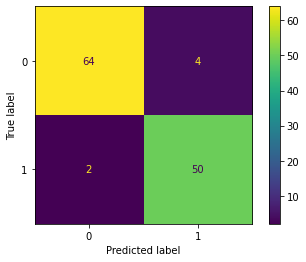

Acc: 0.95


In [286]:
# Create a Perceptron object
perc_no_freq = Perceptron(max_iter=5, tol=None, random_state=5)

perc_no_freq.fit(X_train_tf, Y_train)

# Test the model on the test data
Y_pred = perc_no_freq.predict(X_test_tf)

cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()



# Print accuracy
print( "Acc:", accuracy_score( Y_test, Y_pred) )

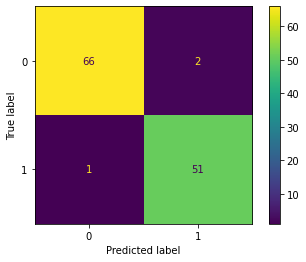

Acc: 0.975


In [287]:
svm_no_freq = SVC(random_state=0)

svm_no_freq.fit(X_train_tf, Y_train)

Y_pred = svm_no_freq.predict(X_test_tf)

cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

print("Acc:", accuracy_score(Y_test, Y_pred))

_____________
## Classification without removing punctuation

Now we train in without removing stopwords, punctuation and without lowercasing the words

In [288]:
df_tokenized = shuffle(df_tokenized)


X = df_tokenized['Text'].apply(lambda x: [token.text for token in nlp(x)]) #We tokenize without removing stopwords, punctuation and do not lower the text
# Join the tokenized sentences into strings
X = [' '.join(tokens) for tokens in X]
Y = df_tokenized['labels_encoded']
Y.shape

(400,)

In [289]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, 
                                                    test_size=0.30, random_state=0)


In [290]:
tfidf_vectorizer = TfidfVectorizer(max_features=400,
                                   use_idf=True,
                                   stop_words='english',
                                   ngram_range=(1, 2))

# Fit the vectorizer to train and test data
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

# Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train_tf.shape)
print('Test:', X_test_tf.shape)
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))

Train: (280, 400)
Test: (120, 400)
Vocabulary size: 400


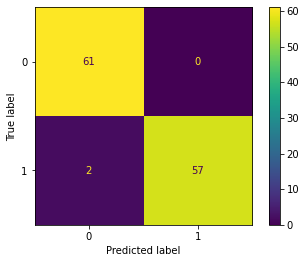

Acc: 0.9833333333333333


In [291]:
# Create a Perceptron object
perc_no_filter = Perceptron(max_iter=5, tol=None, random_state=5)

perc_no_filter.fit(X_train_tf, Y_train)

# Test the model on the test data
Y_pred = perc_no_filter.predict(X_test_tf)

cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()



# Print accuracy
print( "Acc:", accuracy_score( Y_test, Y_pred) )

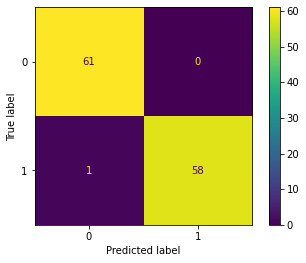

Acc: 0.9916666666666667


In [292]:
svm_no_filter = SVC(random_state=0)

svm_no_filter.fit(X_train_tf, Y_train)

Y_pred = svm_no_filter.predict(X_test_tf)

cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

print("Acc:", accuracy_score(Y_test, Y_pred))